In [44]:
# REF
# https://github.com/jackyko1991/Image-Transform/blob/master/main.py

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import nrrd
import scipy
from numba import cuda
from tqdm import trange

In [46]:
moving_image, header = nrrd.read("20231013_191710_ref_2678_2805.nrrd")
ref_image, header = nrrd.read("20231013_191710_ref_19414_19584.nrrd")

moving_image = moving_image[:,:,::5]
ref_image = ref_image[:,:,::5]

In [47]:
affine_matrix = np.array([[1, 0, 0, 10], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

In [49]:
import scipy.ndimage as ndimage

In [50]:
moving_image = ndimage.affine_transform(ref_image, affine_matrix, output_shape = (ref_image.shape))

In [51]:
moving_image_gpu = np.array(np.clip(moving_image, 0, np.max(moving_image)), dtype=np.uint16)
ref_image_gpu = np.array(np.clip(ref_image, 0, np.max(ref_image)), dtype=np.uint16)
affine_matrix_gpu = np.array(affine_matrix, dtype=np.int16)

In [52]:
moving_image_out_gpu = ndimage.affine_transform(moving_image_gpu, affine_matrix_gpu, output_shape = (ref_image_gpu.shape))
moving_image_out_gpu = ndimage.affine_transform(moving_image_gpu, affine_matrix_gpu, output_shape = (ref_image_gpu.shape))

In [53]:
moving_image_out = (moving_image_out_gpu)

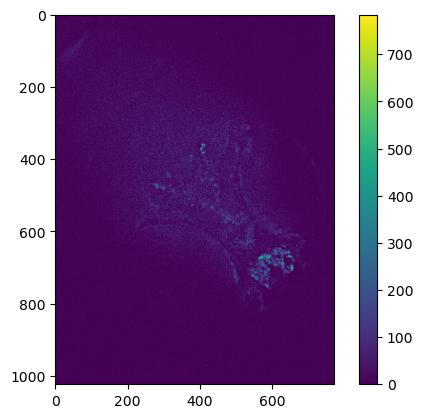

In [54]:
plt.imshow(moving_image_out[:,:,20])
plt.colorbar()

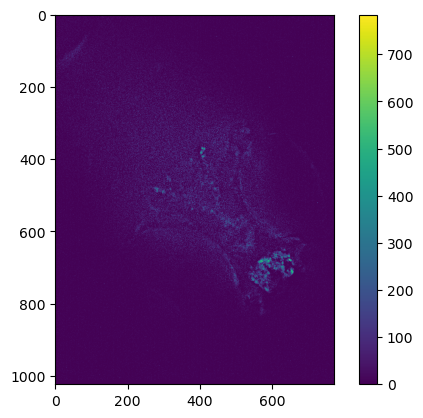

In [55]:
plt.imshow((moving_image_gpu[:,:,20]))
plt.colorbar()

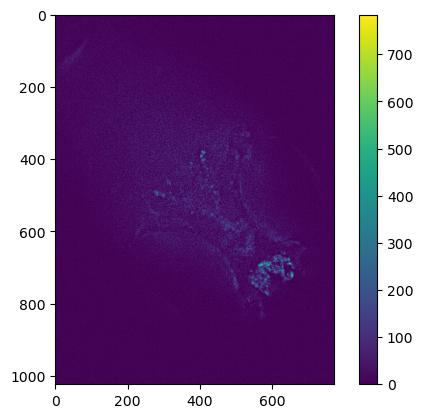

In [56]:
plt.imshow((ref_image_gpu[:,:,20]))
plt.colorbar()

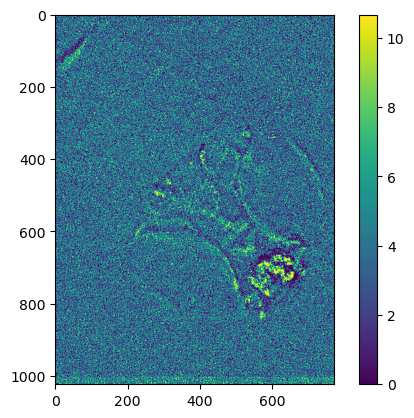

In [64]:
# https://github.com/MedicalImageAnalysisTutorials/ImageRegistrationTutorial/blob/master/m2p_image_registration_example_mse_translation_GradientDescent.ipynb
# mse derivative

# dMSE the derivative of mse with repect to the transform parameters mu
# dM   =  d M(y)/ dy    # gradient of the transformed moving image
# dT   =  d T(x,mu) / dmu # gradient of the transformation with respect to its parameters mu 
# dMdT = d M(y)/ dy * d T(x,mu) / dmu

# compute the gradient of the transformed image

# the first term in eq.4, a scalar

n =  np.product(ref_image_gpu.shape, dtype= np.uint16)
dmse = np.multiply(np.float32(2/n) , (moving_image_out_gpu-ref_image_gpu))

plt.imshow((dmse[:,:, 20]))
plt.colorbar()

dmse = dmse.flatten()

In [68]:
sx = ndimage.sobel(moving_image_out_gpu,axis=0,mode='constant', output = np.int32)
sy = ndimage.sobel(moving_image_out_gpu,axis=1,mode='constant', output = np.int32)
sz = ndimage.sobel(moving_image_out_gpu,axis=2,mode='constant', output = np.int32)

sx = sx.flatten()
sy = sy.flatten()
sz = sy.flatten()

In [59]:
W, H, D = moving_image_out_gpu.shape

In [72]:
x = np.arange(W, dtype = np.uint16)
y = np.arange(H, dtype = np.uint16)
z = np.arange(D, dtype = np.uint16)
x_t, y_t, z_t  = np.meshgrid(x,y,z)
x_t = x_t.flatten()
y_t = y_t.flatten()
z_t = z_t.flatten()

In [76]:
dMu  = np.array([
        np.sum(x_t*sx*dmse, dtype=np.float32), np.sum(y_t*sx*dmse, dtype=np.float32), np.sum(z_t*sx*dmse, dtype=np.float32), np.sum(sx*dmse, dtype=np.float32),
        np.sum(x_t*sy*dmse, dtype=np.float32), np.sum(y_t*sy*dmse, dtype=np.float32), np.sum(z_t*sy*dmse, dtype=np.float32), np.sum(sy*dmse, dtype=np.float32),
        np.sum(x_t*sz*dmse, dtype=np.float32), np.sum(y_t*sz*dmse, dtype=np.float32), np.sum(z_t*sz*dmse, dtype=np.float32), np.sum(sz*dmse, dtype=np.float32),
         ])

In [77]:
dMu

array([-3.7604167e+00, -7.3466372e+10, -9.6234310e+08, -8.6801152e+07,
        1.4677393e+10,  1.0188490e+10,  1.4383934e+08,  1.7695752e+07,
        1.4677393e+10,  1.0188490e+10,  1.4383934e+08,  1.7695752e+07],
      dtype=float32)

In [82]:
numIterations = 10
stepSize = 10**-10
nMu = np.array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])
for i in trange(numIterations):
    affine_matrix = np.vstack([nMu.reshape(3,4), [0,0,0,1]])
    v = ndimage.affine_transform(moving_image_gpu, affine_matrix_gpu, output_shape = (ref_image_gpu.shape))


    dmse = np.multiply(np.float32(2/n) , (moving_image_out_gpu-ref_image_gpu))
    dmse = dmse.flatten()

    
    sx = ndimage.sobel(moving_image_out_gpu,axis=0,mode='constant', output = np.int32)
    sy = ndimage.sobel(moving_image_out_gpu,axis=1,mode='constant', output = np.int32)
    sz = ndimage.sobel(moving_image_out_gpu,axis=2,mode='constant', output = np.int32)
    
    sx = sx.flatten()
    sy = sy.flatten()
    sz = sy.flatten()

    dMu  = np.array([
            np.sum(x_t*sx*dmse, dtype=np.float32), np.sum(y_t*sx*dmse, dtype=np.float32), np.sum(z_t*sx*dmse, dtype=np.float32), np.sum(sx*dmse, dtype=np.float32),
            np.sum(x_t*sy*dmse, dtype=np.float32), np.sum(y_t*sy*dmse, dtype=np.float32), np.sum(z_t*sy*dmse, dtype=np.float32), np.sum(sy*dmse, dtype=np.float32),
            np.sum(x_t*sz*dmse, dtype=np.float32), np.sum(y_t*sz*dmse, dtype=np.float32), np.sum(z_t*sz*dmse, dtype=np.float32), np.sum(sz*dmse, dtype=np.float32),
             ])
    nMu = nMu - ( stepSize * dMu )


100%|██████████| 10/10 [01:18<00:00,  7.86s/it]


In [84]:
nMu

array([ 3.86041365e+01,  7.34663725e+01,  9.62343141e-01,  8.68011545e-02,
       -1.46773934e+01, -9.18849015e+00, -1.43839344e-01, -1.76957517e-02,
       -1.46773934e+01, -1.01884902e+01,  8.56160656e-01, -1.76957517e-02])

In [18]:
# # image registration using gradient descent
# def gdOptimiser(u,v,numIterations,stepSize):
#     # initial parameters 
#     nMu = [0,0]
#     dT = np.array([[1,0],[0,1]])
#     # start the optimisation
#     for i in range(numIterations):
#         # transform the moving image using nMu
#         v_t = imTransform(v,nMu)
#         tMshow = 0
#         if tMshow:
#             f = plt.figure();f.set_figheight(15);f.set_figwidth(15)
#             f.add_subplot(1,2, 1)
#             plt.imshow(v_t)
#         #compute the metric value
#         mv = mseMetric(u,v_t)
#         # compute the metric derivative
#         dMu = mbdMSE(u,v_t,dT)        
#         # update the parameters 
#         nMu = np.array(nMu) - ( stepSize * np.array(dMu ))
#         print(i,": ",mv," , ", nMu)
#     return nMu

# print("numIterations : ", numIterations)
# print("stepSize      : ", stepSize)   

# # numIterations = 119
# # stepSize      = 15